**(Dynamic) Thompson Sampling, as described in Gupta et al. - 2011 - Thompson sampling for dynamic multi-armed bandits**

> Thompson sampling is a probabilistic approach to solve the Multi-Armed Bandit. This paper modifies the original algorithm to make it handle distribution changes during the execution

The Thompson Sampling in this paper considers that each arm is a Bernoulli trial, having the output set ${0, 1}$, with $\theta^k$ denoting the probability of success for arm $k$.

The probability distribution of successes $S$ obtained in $n^k$ trials is a Binomial distribution:

$$p(S = s|\theta^k) = \binom{n^k}{s} (1-\theta^k)^{n-s}(\theta^k)^s.$$

The Beta distribution is a conjugate prior (is of the same probability distribution family as the prior probability, which is the Binomial distribution), parameterized by $\alpha_0$ and $\beta_0$:

$$p(\widehat{\theta}^k; \alpha_0, \beta_0) = \frac{x^{\alpha_0-1}(1-x)^{\beta_0-1}}{B(\alpha_0, \beta_0)},$$

with $B$ being a binonial distribution.

> We use conjugate prior to derive a closed-form expression for the posterior distribution, usually easier to interpret, manipulate and update. In Bayesian statistics, we adjust the hyperparameters of the posterior distribution to optimize the likelihood with the prior distribution.

The **original Thompson sampling** updates $\alpha_n$ and $\beta_n$ for the $n$-th trial, with reward $r_n$ as:

$$\alpha^k_ n = \alpha^k_{n-1} + r_n,$$
$$\beta^k_ n = \beta^k_{n-1} + (1-r_n).$$

The proposed method extends the original algorithm by inserting a new update rule based on an hyperparameter $C$. $C$ is a threshold that provides exponential weighting of the outcomes of the trials, making more recent rewards getting more weight. This way, if prior distributions change during the execution, the learned posterior distributions would respond to it.

We update $\alpha_n$ and $\beta_n$ conditionally based on $C$:

If $\alpha_{n-1}+\beta_{n-1}<C$, we use the original Thompson Sampling. Otherwise, we update

$$\alpha^k_ n = (\alpha^k_{n-1} + r_n)\frac{C}{C+1},$$
$$\beta^k_ n = (\beta^k_{n-1} + (1-r_n))\frac{C}{C+1}.$$

> The paper suggest initializing all $\alpha$ and $\beta$ with the value $2$ for all arms.

The remaining of the paper performs an sensitivity analysis and some experiments to check how well the Dynamic Thompson Sampling performs.

> In our work, the mutations would be the arms, and this update would be used during the evolution to adjust the mutation probabilities.

> Brush originally sample the mutations using an uniform distribution. This algorithm learns hyperparameters to Beta distributions. Somehow we need to convert them to have a transparent implementation to the user.

My suggestion is that, at the end of the evolution, we use the success ratio of each arm as the weights for each arm.

In [1]:
import numpy as np

class D_TS:
    def __init__(self, num_bandits, C=100):
        self.num_bandits = num_bandits

        # Store learner status when the update function is called
        self.pull_history = {
            c:[] for c in ['t', 'arm idx', 'reward', 'update'] + 
                          [f'alpha {i}'  for i in range(num_bandits)] + 
                          [f'beta {i}'   for i in range(num_bandits)] + 
                          [f'weight {i}' for i in range(num_bandits)] } 

        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self._alphas = 2*np.ones(num_bandits) # Paper suggests starting with 2's
        self._betas  = 2*np.ones(num_bandits)
        self.C       = C # how to define this value???

    @property
    def probabilities(self):
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses the learned distributions to randomly choose an arm to pull. 
        
        Returns the index of the arm that was choosen based on the Beta
        probabilities of previous successes and fails.
        """
        
        # probability estimates from the beta distribution
        thetas = np.random.beta(self._alphas, self._betas)
        
        arm_idx = np.argmax(thetas)
        
        return arm_idx
    
    def update(self, arm_idx, reward):
        # There are informations about state. we'll save the pull history of
        # other stuff after updating their values
        self.pull_history['t'].append( len(self.pull_history['t']) )
        self.pull_history['arm idx'].append( arm_idx )
        self.pull_history['reward'].append( reward )
        
        if self._alphas[arm_idx] + self._betas[arm_idx] < self.C:
            # This is the pure thompson scheme
            self._alphas[arm_idx] = self._alphas[arm_idx]+reward
            self._betas[arm_idx]  = self._betas[arm_idx]+(1-reward)

            self.pull_history['update'].append( 0 )
        else:
            # This is the dynamic adjust
            self._alphas[arm_idx] = (self._alphas[arm_idx]+reward)*(self.C/(self.C+1))
            self._betas[arm_idx]  = (self._betas[arm_idx]+(1-reward))*(self.C/(self.C+1))

            self.pull_history['update'].append( 1 )

        # How to transform our Beta distributions into node probabilities?
        # onde idea is to return the expected value of this distribution as
        # the weight that will be given to each arm. In the case of our prior
        # (which is a beta distribution), the expected value is given by
        # 1 / (1 + beta/alpha)
        #self._probabilities = 1 / (1 + (self._betas/self._alphas))
        self._probabilities = (self._alphas-1)/(self._alphas+self._betas-2)

        # Now that we finished updating the values we save them to the logs
        for i in range(self.num_bandits):
            self.pull_history[f'alpha {i}'].append( self._alphas[i] )
            self.pull_history[f'beta {i}'].append( self._betas[i] )
            self.pull_history[f'weight {i}'].append( self.probabilities[i] )


        return self

In [2]:
def plot_learner_history(learner, arm_labels=[]):
    !pip install matplotlib > /dev/null
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # getting the labels to use in plots
    if len(arm_labels) != learner.num_bandits:
        arm_labels = [f'arm {i}' for i in range(learner.num_bandits)]

    # Setting up the figure layout
    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    gs = gridspec.GridSpec(6, 6)

    learner_log = pd.DataFrame(learner.pull_history).set_index('t')
                
    total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
    total_pulls   = learner_log['arm idx'].value_counts().to_dict()

    data_total_pulls    = np.array([total_pulls[k] for k in sorted(total_pulls)])
    data_total_rewards  = np.array([total_rewards[k] for k in sorted(total_rewards)])
    data_total_failures = data_total_pulls-data_total_rewards

    axs = fig.add_subplot(gs[0:2, 4:])
    axs.bar(arm_labels, data_total_failures, label="Null reward")
    axs.bar(arm_labels, data_total_rewards, bottom = data_total_failures, label="Positive reward")
    axs.set_xlabel("Arm")
    axs.legend()

    win_ratios = pd.DataFrame.from_dict({
        'arm'      : arm_labels,
        'totpulls' : data_total_pulls,
        '0 reward' : data_total_failures,
        '+ reward' : data_total_rewards,
        'success%' : (data_total_rewards/(data_total_pulls)).round(2)
    })

    axs = fig.add_subplot(gs[3:5, 4:])
    axs.table(cellText=win_ratios.values, colLabels=win_ratios.columns, loc='center')
    axs.axis('off')
    axs.axis('tight')

    # Plotting rewards and pulls -----------------------------------------------
    # plot the cumulative number of pulls (for evaluations, not generations) ---
    data = np.zeros( (learner_log.shape[0]+1, 4) )
    for i, row in learner_log.iterrows():
        data[i+1, :] = data[i]
        data[i+1, row['arm idx'].astype(int)] += 1

    axs = fig.add_subplot(gs[0:2, :4])
    axs.plot(data, label=arm_labels)
    axs.set_ylabel("Number of times mutation was used")

    # multiple lines all full height showing when D-TS used the dynamic update rule
    plt.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
               ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    # Plotting alphas and betas ------------------------------------------------
    for i, col in enumerate(['alpha', 'beta']):
        columns = learner_log.columns[learner_log.columns.str.startswith(f'{col} ')]
        labels  = [f"{col} {arm_labels[i]}" for i in range(4)] 
        data    = learner_log.loc[:, columns]

        axs = fig.add_subplot(gs[(i+1)*2:(i+1)*2+2, :4])
        axs.plot(data, label=labels)
        axs.set_ylabel(f"{col}s")
        axs.legend()

        # multiple lines all full height showing when D-TS used the dynamic update rule
        axs.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
                ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)
    
    axs.set_xlabel("Evaluations") # Label only on last plot

    plt.show()

------------------------ optimizing ------------------------


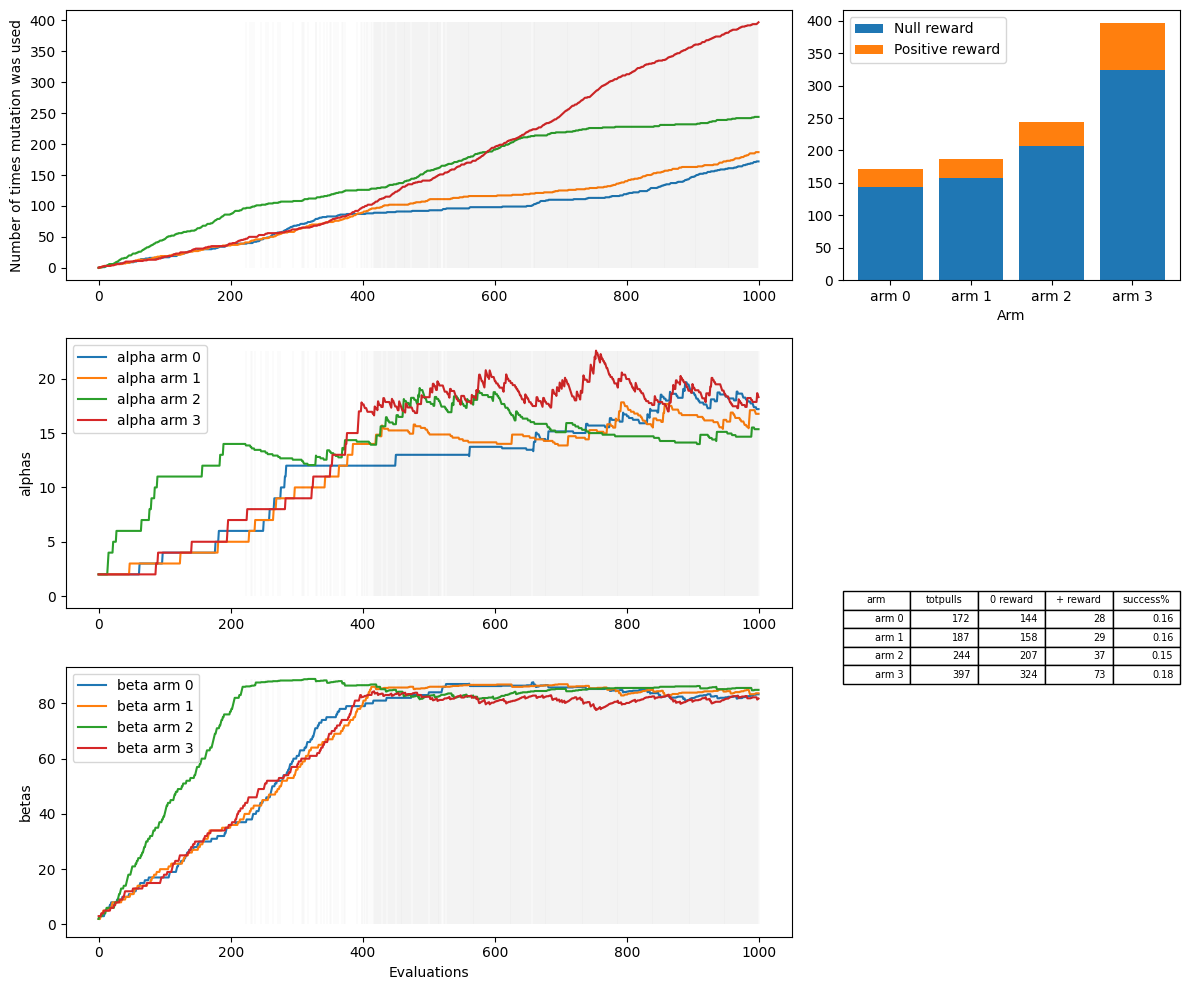

(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------


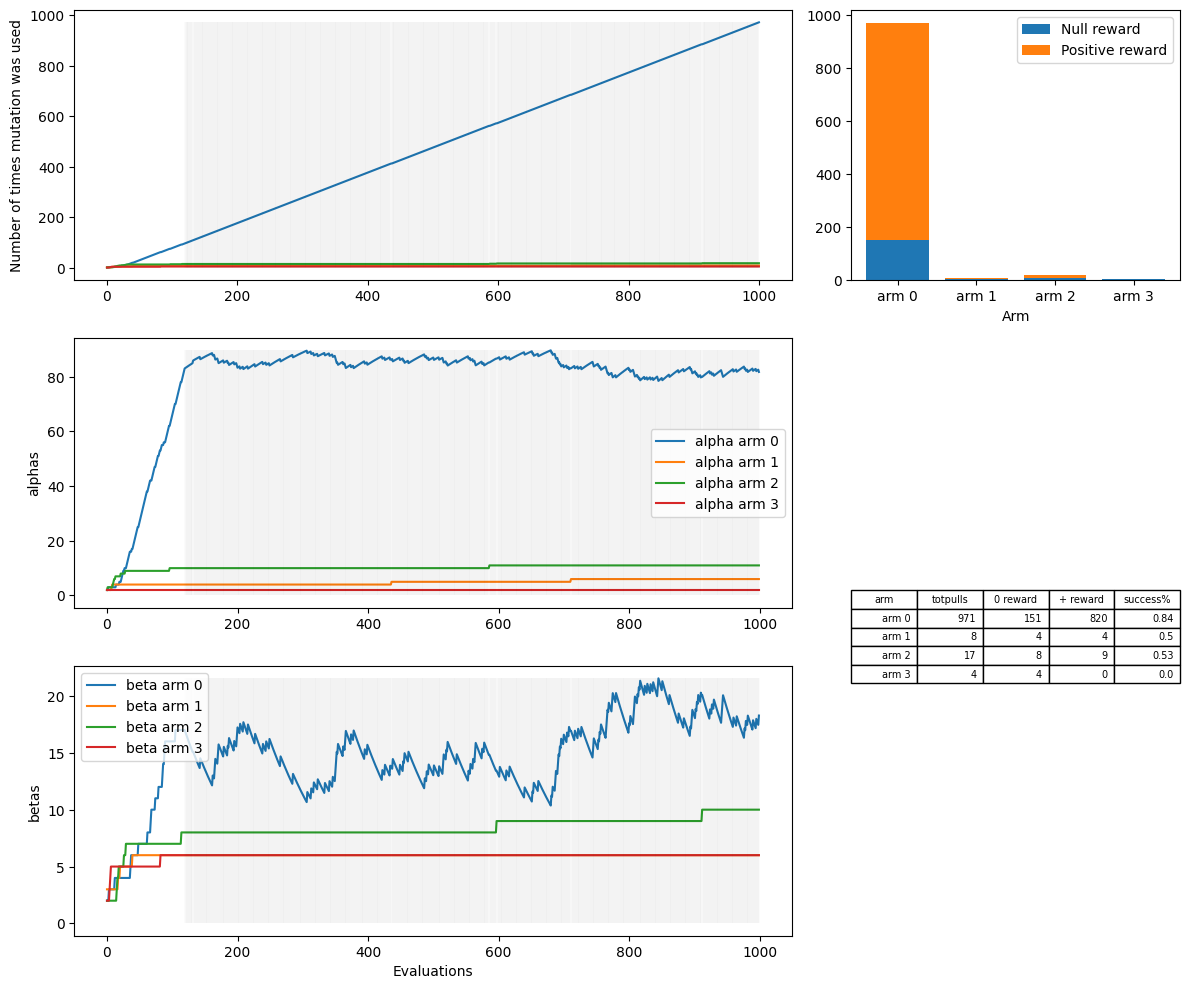

(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------


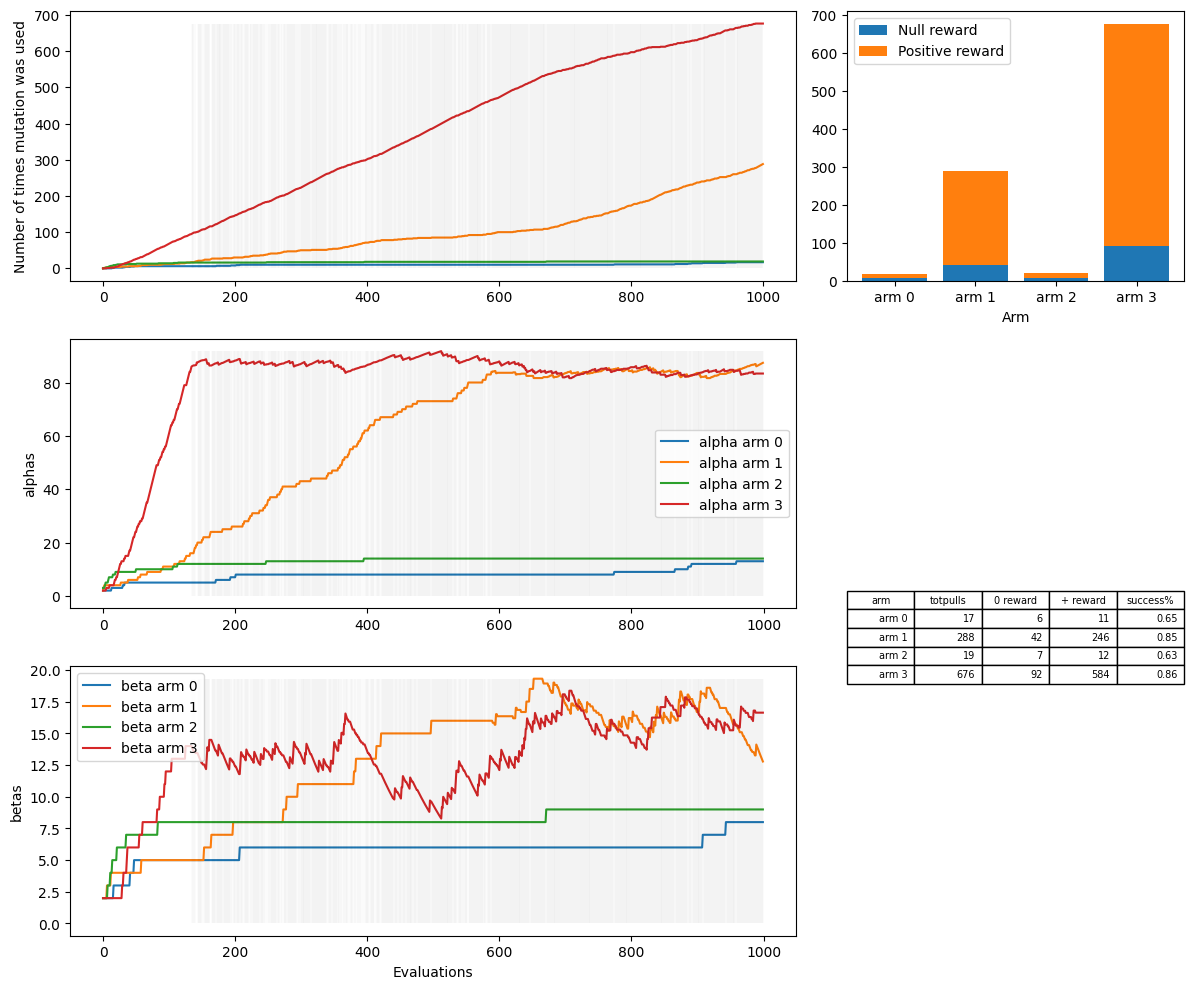

(it was expected: 2nd approx 4th > 1st > 3rd)


In [3]:
# Sanity checks
import pandas as pd

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1 if result > self.reward_prob[arm_idx] else 0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_TS(4)
    for i in range(1000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    plot_learner_history(learner)
    print(f"(it was expected: {expec})")

In [4]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # mutations optimized by the learner. Learner arms correspond to
        # these mutations in the order they appear here
        self.mutations_ = ['point', 'insert', 'delete', 'toggle_weight']

        # Whether the learner should update after each mutation, or if it should
        # update only after a certain number of evaluations.
        # Otherwise, it will
        # store all rewards in gen_rewards_ (which is reseted at the beggining
        # of every generation) and do a batch of updates only after finishing
        # mutating the solutions.
        self.batch_size_    = self.pop_size #
        self.batch_rewards_ = []

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        
        params = self.get_params()
        
        # if the mutation returns an invalid expression, this should count as reward=0
        # ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
        #                             or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        # if ignore_this_time:
        #     for i, m in enumerate(self.mutations_):
        #         params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        # else:
            # mutation_idx = self.learner_.choose_arm()

            # for i, m in enumerate(self.mutations_):
            #     params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        mutation_idx = self.learner_.choose_arm()

        for i, m in enumerate(self.mutations_):
            params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        opt = ind1.prg.mutate()

        if opt:
            offspring = creator.Individual(opt)
            # print("mutation")
            # print(ind1.prg.get_model())
            # print(offspring.prg.get_model())

            offspring.fitness.values = self.toolbox_.evaluate(offspring)
            
            # We compare fitnesses using the deap overloaded operators
            # from the docs: When comparing fitness values that are **minimized**,
            # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
            # (this means that this comparison should work agnostic of min/max problems,
            # or even a single-objective or multi-objective problem)
            reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
            
            # if not ignore_this_time:
            #     self.batch_rewards_.append( (mutation_idx, reward) )

            self.batch_rewards_.append( (mutation_idx, reward) )

            if len(self.batch_rewards_) >= self.batch_size_:
                for (mutation_idx, reward) in self.batch_rewards_:
                    self.learner_.update(mutation_idx, reward)
                self.batch_rewards_ = []
            
            return offspring

        return None

    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_TS(4, C=self.pop_size) # C=self.pop_size

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.logbook_ = logbook
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
        )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

In [5]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    data = pd.read_csv('../../docs/examples/datasets/d_example_patients.csv')
    X = data.drop(columns='target')
    y = data['target']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : True,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            print(f"est, ", end='\n' if (i==29) else '')
            est     = BrushRegressor(**kwargs).fit(X,y)
            print(f"fit, ", end='\n' if (i==29) else '')
            est.score(X,y)

            print(f"est_mab, ", end='\n' if (i==29) else '')
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)
            print(f"fit, ", end='\n' if (i==29) else '')
            est_mab.score(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, est, gen	evals	offspring	ave          	std                    	min      
0  	100  	         	[  nan 20.73]	[       nan 1.00851376]	[nan 17.]
1  	91   	91       	[  nan 15.62]	[       nan 5.93258797]	[nan  1.]
2  	97   	97       	[ nan 8.75]  	[       nan 5.11541787]	[nan  1.]
3  	100  	100      	[ nan 3.67]  	[       nan 2.18657266]	[nan  1.]
4  	100  	100      	[ nan 1.89]  	[       nan 0.96845237]	[nan  1.]
5  	100  	100      	[0.63582207 1.14      ]	[0.26436657 0.34698703]	[0.31053385 1.        ]
6  	100  	100      	[0.49312953 1.07      ]	[0.12367445 0.25514702]	[0.27511281 1.        ]
7  	100  	100      	[0.41630859 1.04      ]	[0.08465657 0.19595918]	[0.27511281 1.        ]
8  	100  	100      	[0.38476919 1.03      ]	[0.01781903 0.2215852 ]	[0.24656506 1.        ]
9  	100  	100      	[0.38476919 1.03      ]	[0.01781903 0.2215852 ]	[0.24656506 1.        ]
10 	100  	100      	[0.38279961 1.07      ]	[0.02629828 0.45287967]	[0.19034052 1.        ]
11 	100  	100      	[0.38225459 

In [ ]:
def generate_plots():
    # Approximating the percentage of usage for each generation ----------------
    # TODO: test if different batch sizes will produce different plots here
    data = np.zeros( (kwargs['max_gen'], 4) )
    for g in range(kwargs['max_gen']):
        idx_start = g*(learner_log.shape[0]//kwargs['max_gen'])
        idx_end   = (g+1)*(learner_log.shape[0]//kwargs['max_gen'])

        df_in_range = learner_log.iloc[idx_start:idx_end]
        g_data = df_in_range['arm idx'].value_counts(normalize=True).to_dict()
        for k, v in g_data.items():
            data[g, k] = v

    plt.figure(figsize=(10, 5))

    #plt.plot(data, label=est_mab.mutations_)
    plt.stackplot(range(kwargs['max_gen']), data.T, labels=est_mab.mutations_)
    plt.xlabel("Generations")
    plt.ylabel("Percentage of usage")

    plt.legend()
    plt.show()

    # average Brush weights for each generation --------------------------------
    data = np.zeros( (kwargs['max_gen'], 4) )
    for g in range(kwargs['max_gen']):
        idx_start = g*(learner_log.shape[0]//kwargs['max_gen'])
        idx_end   = (g+1)*(learner_log.shape[0]//kwargs['max_gen'])

        df_in_range = learner_log.iloc[idx_start:idx_end]
        df_in_range = df_in_range[[col for col in df_in_range.columns if col.startswith('weight')]]
        data[g] = df_in_range.mean().values

    plt.figure(figsize=(10, 5))

    #plt.plot(data, label=est_mab.mutations_)
    plt.stackplot(range(kwargs['max_gen']), data.T, labels=est_mab.mutations_)
    plt.xlabel("Generations")
    plt.ylabel("Percentage of usage")

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    logbook = pd.DataFrame(columns=['gen', 'evals', 'ave m1', 'ave m2',
                                    'std m1', 'std m2', 'min m1', 'min m2'])
    for item in est_mab.logbook_:
        # I'll store the calculate
        logbook.loc[item['gen']] = (
            item['gen'], item['evals'], *item['ave'], *item['std'], *item['min']
        )

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    x = logbook['gen']
    for i, metric in enumerate(['m1', 'm2']):
        y     = logbook[f'ave {metric}']
        y_err = logbook[f'std {metric}']
        y_min = logbook[f'min {metric}']

        axs[i].plot(x, y, 'b', label='Avg.')
        axs[i].fill_between(x, y-y_err, y+y_err, fc='b', alpha=0.5, label="Std.")
        axs[i].plot(x, y_min, 'k', label='Min.')

        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Score" if metric=='m1' else "Size")
        axs[i].legend()

    plt.show()

plot_learner_history(est_mab.learner_)
generate_plots()

## Classification problem

In [ ]:
if __name__ == '__main__':
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    #X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est = BrushClassifier(**kwargs).fit(X,y)
            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

In [ ]:
plot_learner_history(est_mab.learner_)
generate_plots()